In [30]:
## Module Import

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn   #pytorch module 중 NN 설계와 관련한 함수들 모아 놓은 모듈
import torch.nn.functional as F #torch.nn 중 자주 쓰는 함수들
from torchvision import transforms, datasets

In [31]:
## Check Device

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch versioin: ', torch.__version__, 'Device: ', DEVICE)


Using PyTorch versioin:  1.7.1 Device:  cpu


In [32]:
BATCH_SIZE = 32
EPOCHS = 10

In [33]:
## Download FashionMNIST Data

train_dataset = datasets.FashionMNIST(root = "data/FashionMNIST",
                                      train = True, #train data
                                      download = True,  #download from internet
                                      transform = transforms.ToTensor())    #transform image to tensor

test_dataset = datasets.FashionMNIST(root = "data/FashionMNIST",
                                     train = False, #test data
                                     transform = transforms.ToTensor())

# divide data into batches
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)
                                

0it [00:00, ?it/s]Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz to data/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz
 99%|█████████▉| 26279936/26421880 [00:20<00:00, 2195012.38it/s]Extracting data/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to data/FashionMNIST\FashionMNIST\raw

0it [00:00, ?it/s]Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz to data/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz

 56%|█████▌    | 16384/29515 [00:00<00:00, 58880.03it/s]

0it [00:00, ?it/s]Extracting data/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data/FashionMNIST\FashionMNIST\raw


  0%|          | 0/4422102 [00:00<?, ?it/s]

  0%|          | 16384/4422102 [00:00<01:15, 58496.21it/s]

  1%|          | 49152/4422102 [00:01<01:03, 68530.54it/s]

  2%|▏         | 106496/4422102 [00:01<00:50, 85381.13it/s]

  5%|▌         | 229376/4422102 [00:01<00:37, 

In [34]:
## Check Data

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break
# X_train:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
# y_train:  torch.Size([32]) type:  torch.LongTensor

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


26427392it [07:49, 56282.40it/s]  


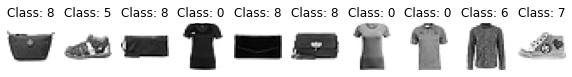

In [35]:
## Check Image Data

pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [36]:
## Design AutoEncoder(AE) Module 

class AE(nn.Module):    #딥러닝 모델 관련 함수 포함하는 nn.Module 클래스 상속 받는 Net 클래스
    def __init__(self): #AE 클래스의 instance가 지니게 되는 성질 정의하는 메서드
        super(AE, self).__init__()  #nn.Module 내의 메서드 상속받아 이용

        self.encoder = nn.Sequential(   #define encoder-> Sequential() 이용해 인코더 한 번에 정의
            nn.Linear(28*28, 512),
            nn.ReLU(),  
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256,32),
        )
        #decoder -> uses Latent Variable Vector generated from encoding as input
        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
        )
    
    def forward(self, x):   #define forward propagation on encoder & decoder
        encoded = self.encoder(x)   #save Latent Variable Vector
        decoded = self.decoder(encoded) #use Latent Variable Vector as decoder's input 
        return encoded, decoded #return Encoded and decoded values


In [37]:
## Set Optimizer and Objective Function

model = AE().to(DEVICE) #AE모델 디바이스에 할당
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)    #update parameters through back propagation
criterion = nn.MSELoss()    #calculate MeanSqaredError between the input image and restored image

print(model)

# AE(
#   (encoder): Sequential(
#     (0): Linear(in_features=784, out_features=512, bias=True)
#     (1): ReLU()
#     (2): Linear(in_features=512, out_features=256, bias=True)
#     (3): ReLU()
#     (4): Linear(in_features=256, out_features=32, bias=True)
#   )
#   (decoder): Sequential(
#     (0): Linear(in_features=32, out_features=256, bias=True)
#     (1): ReLU()
#     (2): Linear(in_features=256, out_features=512, bias=True)
#     (3): ReLU()
#     (4): Linear(in_features=512, out_features=784, bias=True)
#   )
# )

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [38]:
## Training Module

def train(model, train_loader, optimizer, log_interval):
    model.train()   #AE 모델 학습 상대로 지정
    #입력 데이터 타깃으로 학습 -> 레이블 데이터 이용할 필요X -> 레이블 값 '_'로 대신 설정해 생략
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.view(-1, 28 * 28).to(DEVICE)    #image data DEVICE에 할당
                                                    #AutoEncoder input 1ckdnjs -> 2차원 이미지 1차원으로 재구성해 할당
        target = image.view(-1, 28 * 28).to(DEVICE)   
        optimizer.zero_grad() #과거에 이용한 데이터로 인해 계산된 loss의 gradient값 초기화
        encoded, decoded = model(image) #image data 이용해 output 계산
        loss = criterion(decoded, target)   #MeanSqaredError 이용해 loss 값 계산
        loss.backward() #Back Propagation 통해 계산된 Gradient값 각 파라미터에 할당
        optimizer.step()    #각 파라미터별 할당된 gradient 값으로 파라미터 업데이트 

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))



In [39]:
# Evaluate Model

def evaluate(model, test_loader):
    model.eval()    #학습 완료된 모델 평가 상태로 지정
    test_loss = 0   #test_loader 내의 데디터로 loss 값 계산
    real_image = [] #AutoEncoder에 이용되는 실제 이미지 저장하는 리스트
    gen_image = []  #AutoEncoder 통해 생성되는 이미지 저장하는 리스트
    with torch.no_grad():   #torch.no_grad(): 모델 평가하는 단계에서 gradient update 일어나지 않게 함
        for image, _ in test_loader:   #batch 내의 이미지 차례대로 접근
            image = image.view(-1, 28 * 28).to(DEVICE)    #28*28크기의 1차원 데이터로 재구성해 할당
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, decoded = model(image) #output 계산

            #AutoEncoder 통해 생성된 이미지와 실제 이미지간의 MeanSquaredError 값 계산 -> test_loss 업데이트
            test_loss += criterion(decoded, image).item()   
            real_image.append(image.to("cpu"))  #실제 이미지 real_image 리스트에 추가
            gen_image.append(decoded.to("cpu")) #생성된 이미지 gen_image 리스트에 추가

    test_loss /= len(test_loader.dataset)    #계산된 test_loss 값 batch 개수만큼 나눠 평균 loss 값 구함
    return test_loss, real_image, gen_image 

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 0.206127
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.028684
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.021842
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.019727
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.016738
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.017905
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.016846
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.017597
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.014703
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.016773

[EPOCH: 1], 	Test Loss: 0.0005


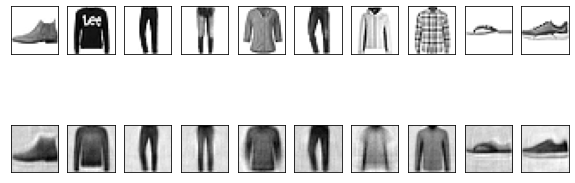

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.013430
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.016709
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.014914
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.014160
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.014500
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.013995
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.013467
Train Epoch: 2 [44800/60000 (75%)]	Train Loss: 0.014389
Train Epoch: 2 [51200/60000 (85%)]	Train Loss: 0.012665
Train Epoch: 2 [57600/60000 (96%)]	Train Loss: 0.012887

[EPOCH: 2], 	Test Loss: 0.0004


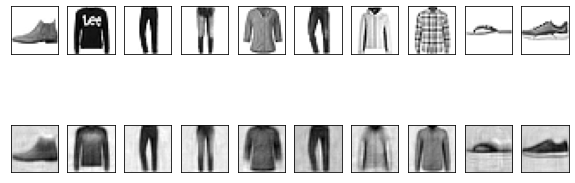

Train Epoch: 3 [0/60000 (0%)]	Train Loss: 0.011946
Train Epoch: 3 [6400/60000 (11%)]	Train Loss: 0.014725
Train Epoch: 3 [12800/60000 (21%)]	Train Loss: 0.013112
Train Epoch: 3 [19200/60000 (32%)]	Train Loss: 0.013592
Train Epoch: 3 [25600/60000 (43%)]	Train Loss: 0.013717
Train Epoch: 3 [32000/60000 (53%)]	Train Loss: 0.011112
Train Epoch: 3 [38400/60000 (64%)]	Train Loss: 0.010489
Train Epoch: 3 [44800/60000 (75%)]	Train Loss: 0.011524
Train Epoch: 3 [51200/60000 (85%)]	Train Loss: 0.011553
Train Epoch: 3 [57600/60000 (96%)]	Train Loss: 0.011813

[EPOCH: 3], 	Test Loss: 0.0004


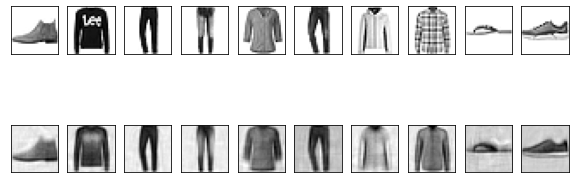

Train Epoch: 4 [0/60000 (0%)]	Train Loss: 0.009425
Train Epoch: 4 [6400/60000 (11%)]	Train Loss: 0.009826
Train Epoch: 4 [12800/60000 (21%)]	Train Loss: 0.011288
Train Epoch: 4 [19200/60000 (32%)]	Train Loss: 0.011308
Train Epoch: 4 [25600/60000 (43%)]	Train Loss: 0.013291
Train Epoch: 4 [32000/60000 (53%)]	Train Loss: 0.013589
Train Epoch: 4 [38400/60000 (64%)]	Train Loss: 0.012300
Train Epoch: 4 [44800/60000 (75%)]	Train Loss: 0.011030
Train Epoch: 4 [51200/60000 (85%)]	Train Loss: 0.012501
Train Epoch: 4 [57600/60000 (96%)]	Train Loss: 0.008936

[EPOCH: 4], 	Test Loss: 0.0003


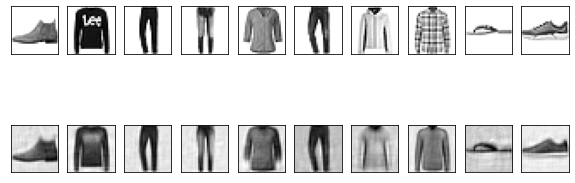

Train Epoch: 5 [0/60000 (0%)]	Train Loss: 0.010589
Train Epoch: 5 [6400/60000 (11%)]	Train Loss: 0.011158
Train Epoch: 5 [12800/60000 (21%)]	Train Loss: 0.009404
Train Epoch: 5 [19200/60000 (32%)]	Train Loss: 0.009695
Train Epoch: 5 [25600/60000 (43%)]	Train Loss: 0.010603
Train Epoch: 5 [32000/60000 (53%)]	Train Loss: 0.013243
Train Epoch: 5 [38400/60000 (64%)]	Train Loss: 0.010269
Train Epoch: 5 [44800/60000 (75%)]	Train Loss: 0.012110
Train Epoch: 5 [51200/60000 (85%)]	Train Loss: 0.012477
Train Epoch: 5 [57600/60000 (96%)]	Train Loss: 0.011837

[EPOCH: 5], 	Test Loss: 0.0003


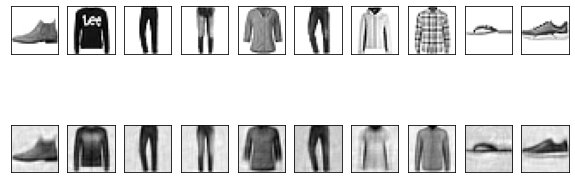

Train Epoch: 6 [0/60000 (0%)]	Train Loss: 0.011985
Train Epoch: 6 [6400/60000 (11%)]	Train Loss: 0.010180
Train Epoch: 6 [12800/60000 (21%)]	Train Loss: 0.009840
Train Epoch: 6 [19200/60000 (32%)]	Train Loss: 0.010511
Train Epoch: 6 [25600/60000 (43%)]	Train Loss: 0.011683
Train Epoch: 6 [32000/60000 (53%)]	Train Loss: 0.009262
Train Epoch: 6 [38400/60000 (64%)]	Train Loss: 0.009767
Train Epoch: 6 [44800/60000 (75%)]	Train Loss: 0.009577
Train Epoch: 6 [51200/60000 (85%)]	Train Loss: 0.010367
Train Epoch: 6 [57600/60000 (96%)]	Train Loss: 0.011347

[EPOCH: 6], 	Test Loss: 0.0003


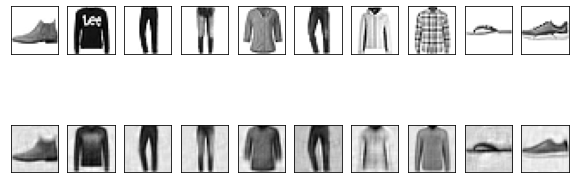

Train Epoch: 7 [0/60000 (0%)]	Train Loss: 0.010296
Train Epoch: 7 [6400/60000 (11%)]	Train Loss: 0.008976
Train Epoch: 7 [12800/60000 (21%)]	Train Loss: 0.008304
Train Epoch: 7 [19200/60000 (32%)]	Train Loss: 0.009785
Train Epoch: 7 [25600/60000 (43%)]	Train Loss: 0.007822
Train Epoch: 7 [32000/60000 (53%)]	Train Loss: 0.009617
Train Epoch: 7 [38400/60000 (64%)]	Train Loss: 0.010400
Train Epoch: 7 [44800/60000 (75%)]	Train Loss: 0.010103
Train Epoch: 7 [51200/60000 (85%)]	Train Loss: 0.009359
Train Epoch: 7 [57600/60000 (96%)]	Train Loss: 0.010060

[EPOCH: 7], 	Test Loss: 0.0003


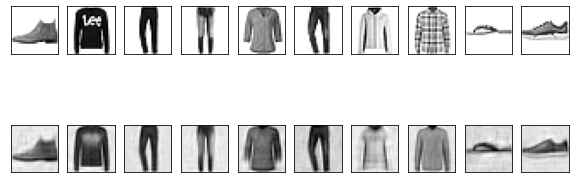

Train Epoch: 8 [0/60000 (0%)]	Train Loss: 0.009155
Train Epoch: 8 [6400/60000 (11%)]	Train Loss: 0.011074
Train Epoch: 8 [12800/60000 (21%)]	Train Loss: 0.011937
Train Epoch: 8 [19200/60000 (32%)]	Train Loss: 0.008885
Train Epoch: 8 [25600/60000 (43%)]	Train Loss: 0.008740
Train Epoch: 8 [32000/60000 (53%)]	Train Loss: 0.010513
Train Epoch: 8 [38400/60000 (64%)]	Train Loss: 0.010458
Train Epoch: 8 [44800/60000 (75%)]	Train Loss: 0.010799
Train Epoch: 8 [51200/60000 (85%)]	Train Loss: 0.008910
Train Epoch: 8 [57600/60000 (96%)]	Train Loss: 0.010033

[EPOCH: 8], 	Test Loss: 0.0003


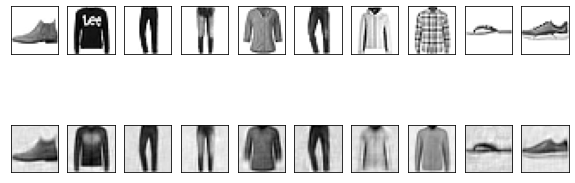

Train Epoch: 9 [0/60000 (0%)]	Train Loss: 0.011161
Train Epoch: 9 [6400/60000 (11%)]	Train Loss: 0.008553
Train Epoch: 9 [12800/60000 (21%)]	Train Loss: 0.011670
Train Epoch: 9 [19200/60000 (32%)]	Train Loss: 0.008565
Train Epoch: 9 [25600/60000 (43%)]	Train Loss: 0.012482
Train Epoch: 9 [32000/60000 (53%)]	Train Loss: 0.009566
Train Epoch: 9 [38400/60000 (64%)]	Train Loss: 0.009686
Train Epoch: 9 [44800/60000 (75%)]	Train Loss: 0.007917
Train Epoch: 9 [51200/60000 (85%)]	Train Loss: 0.009546
Train Epoch: 9 [57600/60000 (96%)]	Train Loss: 0.008819

[EPOCH: 9], 	Test Loss: 0.0003


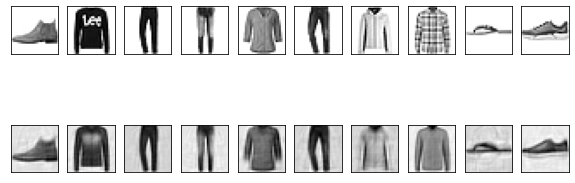

Train Epoch: 10 [0/60000 (0%)]	Train Loss: 0.007402
Train Epoch: 10 [6400/60000 (11%)]	Train Loss: 0.009725
Train Epoch: 10 [12800/60000 (21%)]	Train Loss: 0.009063
Train Epoch: 10 [19200/60000 (32%)]	Train Loss: 0.010484
Train Epoch: 10 [25600/60000 (43%)]	Train Loss: 0.008886
Train Epoch: 10 [32000/60000 (53%)]	Train Loss: 0.008358
Train Epoch: 10 [38400/60000 (64%)]	Train Loss: 0.012661
Train Epoch: 10 [44800/60000 (75%)]	Train Loss: 0.010004
Train Epoch: 10 [51200/60000 (85%)]	Train Loss: 0.010870
Train Epoch: 10 [57600/60000 (96%)]	Train Loss: 0.008883

[EPOCH: 10], 	Test Loss: 0.0003


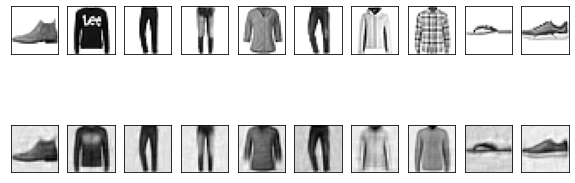

In [40]:
## Model 학습 -> Test set의 Reconstruction Error 확인하기

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize = (10, 4))

    #실제 이미지와 생성된 이미지 비교하며 학습 진행도 확인
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()